In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.testing import (assert_equal, assert_almost_equal,
                           assert_array_equal, assert_array_almost_equal)

## Problem 1 [1 pt]

Create a function `get_reviews` that reads `/mnt/data/public/insideairbnb/data.insideairbnb.com/united-kingdom/scotland/edinburgh/2016-07-09/data/reviews.csv.gz` and returns a DataFrame with each row corresponding to a review. The index should be the review `id` and the first column should be the `reviewer_id`. The rest of the columns should be the TF-IDF representation of the review `comments`. The TF-IDF columns should be sorted alphabetically. 

Use `TfidfVectorizer` to create the TF-IDF representation. Convert the `comments` into lowercase first. For this problem, a word (token) is defined to be a sequence of alphabetical characters prefixed and suffixed by a word boundary. Consider only words that occur in at least 1000 reviews. Follow the idf definition in the previous lecture,
$$\text{idf}_w = \log{\frac{n}{n_w}},$$
Do not normalize the TF-IDF vector of each document. Do not include empty words ('') and drop rows that only have empty words. 

In [2]:
# Import TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


def get_reviews():
    """Return a dataframe with each row corresponding to a review"""

    # Load file
    file = '/mnt/data/public/insideairbnb/data.insideairbnb.com/'\
           'united-kingdom/scotland/edinburgh/2016-07-09/data/reviews.csv.gz'
    df_src = pd.read_csv(file, compression='gzip')
    df = df_src.copy()  # create copy
    df = df.dropna()  # drop n/a
    df = df.reset_index()  # reset index

    # Clean comments column
    df['comments'] = (df['comments'].apply(lambda x: " ".join(
                                       x.lower() for x in x.split())))

    # Vectorize data
    tfidf_vectorizer = TfidfVectorizer(norm=None,
                                       use_idf=False,
                                       token_pattern=r'\b[a-z]+\b',
                                       min_df=1000)
    tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(
                                                        df['comments'])
    df_processed = pd.DataFrame(tfidf_vectorizer_vectors.toarray(),
                                columns=tfidf_vectorizer.get_feature_names())

    # Apply IDF
    n = df_processed.shape[0]
    nw = df_processed.astype(bool).sum()
    idf = np.log(n/nw)
    df_processed = df_processed*idf
    df_tfidf = df_processed.loc[(df_processed.sum(axis=1) != 0)]

    # Retain relevant columns
    df = df[['id', 'reviewer_id']]
    df_final = pd.concat([df, df_tfidf], axis=1)
    df1 = df_final.set_index('id').dropna()

    return df1

In [3]:
df_bow = get_reviews()
assert_array_equal(df_bow.columns[:10], 
                   ['reviewer_id', 'a', 'able', 'about', 'absolutely', 
                    'access', 'accessible', 'accommodating', 'accommodation', 
                    'accurate'])
assert_equal(df_bow.shape, (105390, 621))
assert_equal(df_bow.index[0], 60060297)
assert_equal(df_bow.iloc[0,0], 17059927)
assert_array_equal(df_bow.iloc[0,:].to_numpy().nonzero()[0], 
                   [  0,   7,  25,  65, 123, 193, 206, 213, 245, 274, 333, 
                    353, 358, 362, 402, 450, 466, 495, 511, 519, 569, 582, 
                    588, 589, 595])
assert_almost_equal(df_bow.iloc[0, 7], 3.1663363011050603)

## Problem 2 [1 pt]

Create a function `closest_euc` that accepts `df_bow` and returns the 10 closest review `id`s by increasing Euclidean distance from review `id` `80416123`, precision and recall. A result is considered relevant if it comes from the same `review_id` as the query (`reviewer_id == 24782827`).

In [4]:
# Import package
from scipy.spatial.distance import euclidean


# Get nearest_k function from IR exercise
def nearest_k(query, objects, k, dist):
    """Return the indices to objects most similar to query"""
    return np.argsort([dist(query, obj) for obj in objects])[:k]


# Get get_confusion function from IR exercise
def get_confusion(actual, results, all_labels):
    """Return the confusion matrix as a dataframe"""
    df = pd.DataFrame(all_labels)
    ret_df = df[df.index.isin(results)]
    not_df = df[~df.index.isin(results)]

    TP = sum(ret_df[0] == actual)
    FP = len(ret_df) - TP
    FN = sum(not_df[0] == actual)
    TN = len(not_df) - FN
    con_mat = pd.DataFrame([[TP, FP], [FN, TN]],
                           columns=['relevant', 'irrelevant'],
                           index=['relevant', 'irrelevant'])
    return con_mat


# Get precision function from IR exercise
def precision(confusion):
    """Return the precision from a confusion matrix"""
    TP = confusion.loc['relevant', 'relevant']
    FP = confusion.loc['relevant', 'irrelevant']
    if TP + FP == 0:
        return 1
    return TP/(TP+FP)  # precision formula


# Get recall function from IR exercise
def recall(confusion):
    """Returns the recall from the confusion matrix"""
    TP = confusion.loc['relevant', 'relevant']
    FN = confusion.loc['irrelevant', 'relevant']
    if TP == 0:
        return 0
    return TP/(TP+FN)  # recall formula


# Curate function
def closest_euc(df_bow):
    """Return the 10 closest review IDs by increasing Euclidean distance"""

    # Drop target feature to remove bias
    df_bow_features = df_bow.drop(['reviewer_id'], axis=1)

    # Get closest IDs
    idx = 80416123
    closest_ids_idx = nearest_k(df_bow_features.loc[idx],
                                df_bow_features.to_numpy(),
                                10, euclidean)
    closest_ids_euc = list(df_bow_features.iloc[closest_ids_idx].index)

    # Calculate precision and recall
    target = df_bow['reviewer_id']
    target_all = target.to_numpy()
    target_spec = target.loc[idx]
    confusion = get_confusion(target_spec, closest_ids_idx, target_all)
    p_euc = precision(confusion)
    r_euc = recall(confusion)
    return closest_ids_euc, p_euc, r_euc

In [5]:
closest_ids_euc, p_euc, r_euc = closest_euc(df_bow)
assert_equal(len(closest_ids_euc), 10)

## Problem 3 [1 pt]

Create a function `compute_auc_euc` that accepts `df_bow` and returns the AUC distance when the review `id` `80416123` is the query and Euclidean distance is the metric. A result is considered relevant if it comes from the same `review_id` as the query (`reviewer_id == 24782827`).

In [6]:
# Get auc_pr function from IR exercise
def auc_pr(query, objects, dist, actual, all_labels):
    """Return the area under the PR curve"""

    results = nearest_k(query, objects,
                        len(all_labels), dist)
    series = (pd.Series(all_labels)
              [results] == actual).reset_index(drop=True)

    # Precision
    prec = series.cumsum() / (np.array(series.index) + 1)
    precision_s = pd.concat((pd.Series([1]), prec))

    # Recall
    rec = series.cumsum() / sum(pd.Series(all_labels)
                                [results] == actual)
    recall_s = pd.concat((pd.Series([0]), rec))
    auc = np.trapz(precision_s, recall_s)
    return auc


# Curate functaion
def compute_auc_euc(df_bow):
    """Return the AUC distance when Euclidean distance is the metric"""

    # Drop target variable
    df_bow_features = df_bow.drop(['reviewer_id'], axis=1)

    # Separate the target variable
    target = df_bow['reviewer_id']
    target_all = target.to_numpy()
    idx = 80416123
    target_spec = target.loc[idx]

    # Return area under curve
    auc_euc = auc_pr(df_bow_features.loc[idx],
                     df_bow_features.to_numpy(),
                     euclidean,
                     target_spec,
                     target_all)
    return auc_euc

In [7]:
auc_euc = compute_auc_euc(df_bow)

## Problem 4 [2 pts]

Create a function `closest_quote_cos` that accepts `df_bow` and returns the 10 closest review `id`s by increasing cosine distance from the text "Great place in the heart of the city."

In [8]:
# Import package
from scipy.spatial.distance import cosine


def closest_quote_cos(df_bow):
    "Return the 10 closest review by increasing cosine distance"

    # Load file
    file = '/mnt/data/public/insideairbnb/data.insideairbnb.com/'\
           'united-kingdom/scotland/edinburgh/2016-07-09/data/reviews.csv.gz'
    df_orig = pd.read_csv(file, compression='gzip')

    target = (df_orig[df_orig.comments.str.contains(
              "Great place in the heart of the city.") == True])
    target_id = target['id'].values[0]

    # Drop target variable
    df_bow_features = df_bow.drop(['reviewer_id'], axis=1)

    # Return nearest_k
    closest_ids_idx = nearest_k(df_bow_features.loc[target_id],
                                  df_bow_features.to_numpy(),
                                  10, cosine)
    closest_ids_cos = list(df_bow_features.iloc[closest_ids_idx].index)

    return closest_ids_cos

In [9]:
closest_ids_quote = closest_quote_cos(df_bow)
assert_equal(len(closest_ids_quote), 10)

## Problem 5 [1 pt]
Perform dimensionality reduction on `df_jokes` using one of the methods discussed in class.

In [10]:
# Import package
from sklearn.decomposition import TruncatedSVD

# Drop target feature
df_bow_features = df_bow.drop(['reviewer_id'], axis=1)

# Perform SVD
n_comps = df_bow_features.to_numpy().shape[1] - 1

# NOTE: Hi Prof! This cell takes a long time to run that
## nbgrader's 'Validate' button returns "UnresponsiveKernelError"
svd = TruncatedSVD(n_components=n_comps, random_state=901) 

svd.fit_transform(df_bow_features.to_numpy())

array([[ 2.70555456e+00, -1.40443029e-01, -3.05173942e-03, ...,
        -1.78499682e-02, -1.10423279e-02, -4.37407670e-03],
       [ 5.73786013e+00, -2.53286964e-01,  2.85010444e-02, ...,
         6.21299278e-03, -3.44223008e-02, -3.56039964e-03],
       [ 2.27668314e+00, -9.70879149e-02, -9.17480409e-03, ...,
         1.61821802e-02, -4.15602163e-02, -2.83041860e-03],
       ...,
       [ 6.97213297e+00, -2.74104198e-01, -5.54697150e-02, ...,
         1.09394164e-02, -5.10581302e-02, -6.13337535e-03],
       [ 2.31363378e+00, -1.15006546e-01, -1.28388277e-03, ...,
         6.47150144e-03, -3.13159726e-02, -1.27899511e-03],
       [ 4.40069852e+00, -1.88517223e-01, -1.37009116e-02, ...,
         8.89840516e-03, -3.48932315e-02, -1.73017848e-02]])

## Problem 6 [1 pt]

Justify your choice of dimensionality reduction method.

I reduced the number of dimensions using **Latent Semantic Analysis** or Truncated Singular Value Decomposition (SVD) for text data. The main difference of this technique from the classic Principal Component Analysis (PCA) is that the data does not have to be mean-centered. Given the sparse feature of the matrix in a text analysis (i.e. bag of words), then LSA or Truncated SVD would be more appropriate.

## Problem 7 [1 pt]

How many dimensions did you retain? Justify your choice.

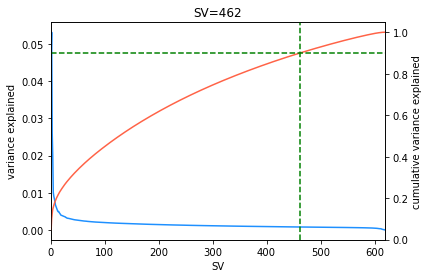

In [11]:
# Plot variance and cumulative variance explained

threshold = 0.9  # setting 90% threshold
nssd = svd.explained_variance_ratio_
thres = np.where(nssd.cumsum() >= 0.90)[0][0] + 1

fig, ax = plt.subplots()
ax.set_title(f'SV={thres}')
ax.plot(range(1, len(nssd)+1), nssd, '-',
        color='dodgerblue', label='individual')
ax.set_xlim(0, len(nssd)+1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained')
ax = ax.twinx()
ax.plot(range(1, len(nssd)+1), nssd.cumsum(),
        color='tomato', label='cumulative')
ax.axhline(threshold, ls='--', color='g')
ax.axvline(thres, ls='--', color='g')
ax.set_ylabel('cumulative variance explained');

The figure above plots the SVs and their corresponding `variance explained` and `cumulative variance explained`. Using a 90% threshold for `cumulative explained variance`, the number of components needed to meet the hurdle is **462** (as illustrated in the green dashed line in the figure above). At this threshold, we are able to capture a significant portion of the variances, and was able to reduce the number of SVs by around ~25%. 

## Problem 8 [2 pts]

Interpret the results of the dimensionality reduction.

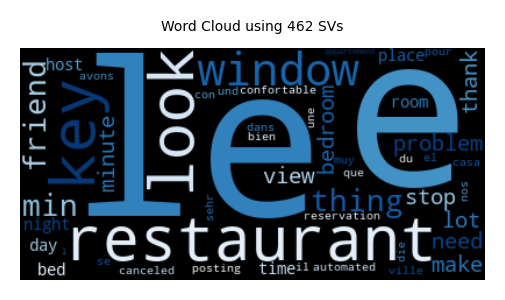

In [12]:
# Import packages
from wordcloud import WordCloud

# Set-up feature names
feature_list = []
p = svd.components_.T
feature_names = df_bow_features.columns
for i in range(thres):
    order = np.argsort(np.abs(p[:, i]))
    feat_names = [feature_names[o] for o in order]
    feature_list.append(feat_names)

# Generate a word cloud
title = f'Word Cloud using {thres} SVs'
words = feature_list[0]
text = ' '.join([word for review in words
                 for word in review.split()])
wordcloud_top = WordCloud(background_color="black",
                          colormap='Blues', max_words=50,
                          collocations=False).generate(text)
plt.figure(figsize=(3, 3), dpi=200)
plt.title(title, fontsize=5)
plt.imshow(wordcloud_top, interpolation='bilinear')
plt.axis("off")
plt.show()

**Interpretation**

The word cloud above uses words from the 462 SVs in df_bow.The most prominent words include, `le`, `e`, `resraurant`, `look`, `key`, `window`, among others. Since this is an Airbnb (Scotland) dataset, it is possible that the reviews are highlighting some aspects of the Airbnb in relation to a `restaurant` (e.g. the Airbnb place being close to a restaurant) and about the `window` of the Airbnb (this could also be related to `look` which may pertain to the view outside the window). The word `le` appears to be prominent as well. This makes sense because places in Scotland typically include `le` such as "Le Monde Hotel" (a known hotel in the country) and "Le Boat" (a tourist attraction in Scotland). 

We can also print out the top 10 words using bar charts as shown below. However, it appears that it is more difficult to extract context if we use this type of chart. Further data clean-up may be needed (e.g. removing stop words, lemmatization, etc) to better contextualize the topics (or SVs).

*Plotting the top 10 SVs using bar charts*

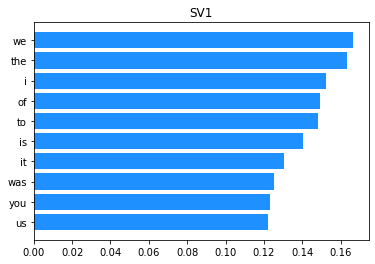

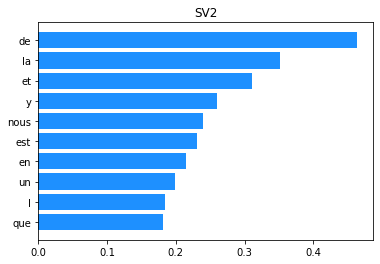

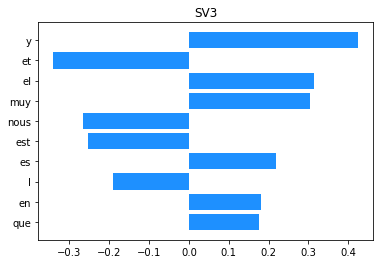

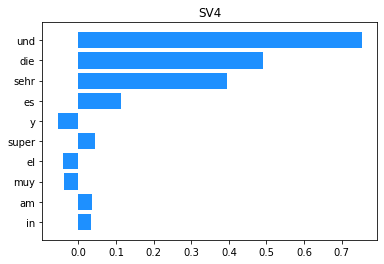

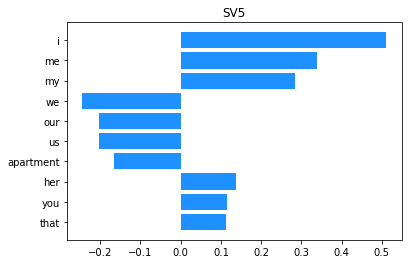

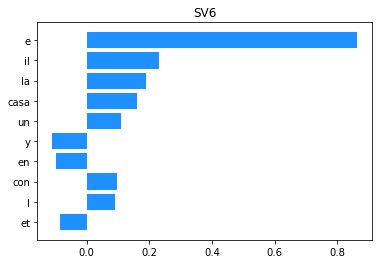

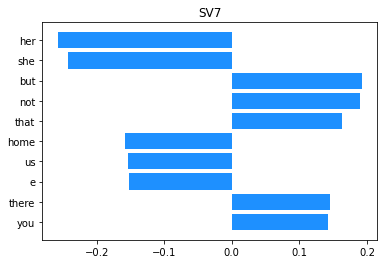

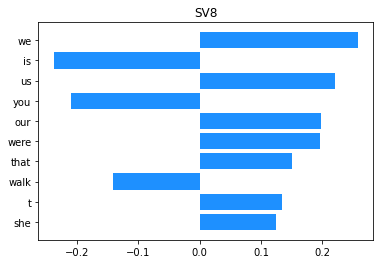

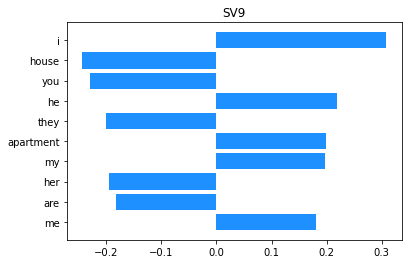

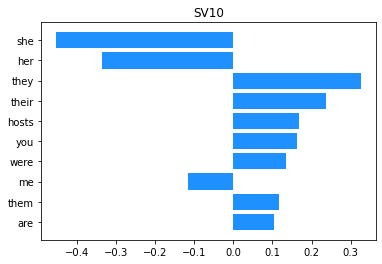

In [13]:
# Get feature names and p
feature_names = df_bow_features.columns
p = svd.components_.T

# Plot first 10 topics
for i in range(10):
    fig, ax = plt.subplots()
    order = np.argsort(np.abs(p[:, i]))[-10:]
    ax.barh([feature_names[o] for o in order], p[order, i], color='dodgerblue')
    ax.set_title(f'SV{i+1}')